# Virus Transmission

A notebook to study the evolution of an epidemic in a simplified context.

Manual of the experiment: https://ap.phys.ethz.ch/Anleitungen/73APen.pdf

For starters, import all needed libraries

In [1]:
import random
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
from scipy.optimize import curve_fit
rg = np.random.default_rng(1234)
import tqdm

## General Setting of the Problem
Consider a squared country populated by NxN individuals in a grid.

Day 0 marks the first day one person gets infected along the North border.

The possible states of a person are:
 - uninfected
 - infected
 - recovered
 - dead

Each day:
 - an infected individual could be infected in general by $k$ close contacts. The probability of infection after a close contact is $p_{Inf}$
 - an infected person could recover (with probability $p_{Reco}$), die (with probability $p_{Death}$), or stay infected (with probability $1-p_{Reco}-p_{Death}$)
 - an individual could move or not move; this will be speficied in each exercise.
 

## Analytic part

To get more context, you can check out the SIR model, e.g. [here](https://www.maa.org/press/periodicals/loci/joma/the-sir-model-for-spread-of-disease-the-differential-equation-model)

Write and solve the differential equation for the total number of infected individuals as a function of time, $I(t)$ (neglect spatial distribution of infections). 

#### Case 1
- free travel, each individual has on average a number of close contacts, $k$.
- each close contact has a probability $p_{Inf}$ of generating a new infection 
- $p_{Reco}$=0
- $p_{Death}$=0

Think at the number of new infections $dI$ in the unit of time $dt$ based on the information you have, and on the boundary conditions.

Answer:

$dI = I(t) \times k \times p_{Inf} \times \frac{U(t)}{N^2}$

$I(0) = I_0$

$U(t) + I(t) = N^2$

Solution of the differential equation:

$I(t) = N^2 \frac{  \frac{I_0}{N^2-I_0} e^{k p_{inf} t}  }{ 1 +  \frac{I_0}{N^2-I_0} e^{k p_{inf} t}    } $

#### Case 2
- restricted travel, infections can only happen with the nearest neighbours (at most 4 NNs) (see picture)
- each close contact has a probability $p_{Inf}$ of generating a new infection 
- $p_{Reco}$=0
- $p_{Death}$=0

Within this setting, what changes in the differential equation above? How the solutions compare in case 1 and 2?

<img src="../images/illustration.png" alt="Drawing" style="width: 400px;"/>

Answer: 

The difference is that one does not have an unrestricted number of close contacts, but only at most 4. So $k<4$.

It is hard to predict the exact value of $k$; it depends on the geometry of the cluster and on $p_{Inf}$

What one can intuitively say is: $k(p_{inf}\ll 1) > k(p_{Inf}\simeq1)$

#### Plot the solution!

Define the function, with arguments:
 - time, t
 - number of individuals, $N^2$
 - number of initial infected, $I_0$ 
 - average number of contacts per individual in a day, $k$
 - probability of infection, $p$

In [2]:
def I(t=0.,N2=100.,I0=1.,k=10.,p=0.1):
  if N2-I0<=0 or t<0: return -1
  a = I0/(N2-I0) * np.exp(k*p*t)
  return N2 * a / (1+a)

Plot it in several cases, e.g. vary $k$

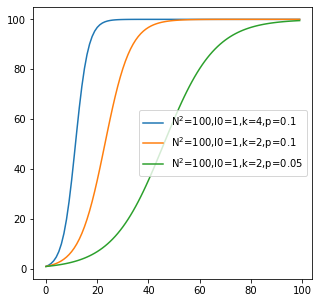

In [3]:
times=np.arange(0,100,1)

fig,ax = plt.subplots(1,1,figsize=(5, 5))

ax.plot(times,np.array([I(t,N2=100,I0=1,k=4,p=0.1) for t in times]),   label='N$^2$=100,I0=1,k=4,p=0.1')
ax.plot(times,np.array([I(t,N2=100,I0=1,k=2,p=0.1) for t in times]),   label='N$^2$=100,I0=1,k=2,p=0.1')
ax.plot(times,np.array([I(t,N2=100,I0=1,k=2,p=0.05) for t in times]),  label='N$^2$=100,I0=1,k=2,p=0.05')


ax.legend(loc='center right', frameon=True) 
plt.show()

## Simulation part

Here is the implementation of the classes to simulate the spread of an epidemic from country A to country B.

Country A is modelled as a NxN grid of inidividuals, like described in the previous sections.

Please also note the following specifications for the simulation:

Position of individuals:
- individuals can occupy discretised positions, organised in a grid of (width=N x height=N)
- each position can only be occupied by one individual at the same time 
- every day each individual can move from its position only by a discrete distance, horizontally and/or vertically or can remain fixed; its condition is updated based on the nearest neighbours of the previous day.

How to track the infection at the border of country B:
- we track if the disease spreads to country B, by adding an additional row of individuals in country A and by counting the infections there.

### Global definitions

In [4]:
'''
Helper dictionary which creates a map between strings and integers for the possible available conditions
'''
CondDict = {}
CondDict['uninfected'] = 0
CondDict['infected'] = 1
CondDict['recovered'] = 2
CondDict['dead'] = 3
CondDict[0] = 'uninfected'
CondDict[1] = 'infected'
CondDict[2] = 'recovered'
CondDict[3] = 'dead'

### Classes definitions

#### Disease 

In [5]:
class Disease(object):
  '''
  The disease, as characterised by the probabilities _pInfection, _pRecovery, _pDeath.
  
  Arguments for initialisation:
  _pInfection:    probability of getting infected 
  _pRecovery:     probability of recovery, if alrady infected 
  _pDeath:        probability of dying, if already infected

  '''
  def __init__(self,pInfection,pRecovery,pDeath):  
    self._pInfection=pInfection
    self._pRecovery=pRecovery
    self._pDeath=pDeath

    if self._pDeath + self._pRecovery >= 1: 
      raise RuntimeError('self._pDeath + self._pRecovery should be < 1')
    if self._pInfection > 1:
      raise RuntimeError('self._pInfection should be <= 1')

#### Individual

In [6]:
class Individual(object):
  '''
  Tracks an individual through time
  The state of an individual consists of:
   - position at a given time 
   - condition at a given time
  '''  

  def __init__(self):
    self._positions = []
    self._conditions = []
    self._times = []


  def setState(self, time=0, pos=(0,0), condition='uninfected'):
    '''
    Sets the state of the individual at time t 
    '''
    self._times.append(time)
    self._conditions.append(condition)
    self._positions.append(pos)

  def updatePosition(self, time=0, pos=(0,0)):
    '''
    Updates postition of an existing state 
    '''       
    try:
      idxTime = self._times.index(time)
      self._positions[idxTime] = pos
    except: 
      print('Requested update of position not possible')

  def updateCondition(self, time=0, condition='infected'):
    '''
    Updates condition of an existing state 
    '''       
    try:
      idxTime = self._times.index(time)
      self._conditions[idxTime] = condition
    except: 
      print('Requested update of condition not possible')    
     
  def getPosition(self,time=0):
    '''
    Returns position of existing state
    '''    
    try:
      idxTime = self._times.index(time)
      return self._positions[idxTime]
    except: 
      print('Requested state does not exist') 
    
  def getCondition(self,time=0):
    '''
    Returns condition of existing state
    '''
    try:
      idxTime = self._times.index(time)
      return self._conditions[idxTime]
    except: 
      print('Requested state does not exist')
    

#### Nation

In [7]:
class Nation(object):
  '''
  Individuals are organised in a nation. This class describes the spread of a disease in a simplified model:
   - individuals can occupy discretised positions, organised in a grid of (width x height)
   - each position can only be occupied by one individual at the same time 
   - each individual can move from its position only by a discrete distance, horizontally and/or vertically
   - initial infection happens on day 0, at the north border and spreads to the nearest neighbours of an infected individual every day
   
  Arguments for initialisation:
    _width : (int) width of the nation
    _height: (int) height of the nation
            N.B.: a nation of height+1 will be created to track the infections in the bordering country
    _I0:     (float) initial number of infected individuals
    _maxTravelDistance: (int) the number of squares that each individual can move on a given day
  '''

  def __init__(self, width=10, height=10, I0=1, maxTravelDistance=0):
    
    if not isinstance(width, int) or not isinstance(height, int) or not isinstance(maxTravelDistance, int) or not isinstance(I0, int)\
    or width<=0 or height<=0 or maxTravelDistance < 0 or I0<=0:
      raise RuntimeError('Width, height, I0 have to be positive integers; maxTravelDistance must be non-negative')

    self._width = width
    self._height = height
    self._maxTravelDistance = maxTravelDistance
    self._I0 = I0

    self._N2 = width * height
    if self._I0 > self._width: raise RuntimeError('Initial number of infected individuals cannot exceed number of individuals at the border. Please lower I0')

    self._individuals = [] 
    self._currentTime = 0
 
  def createIndividuals(self):
    '''
    Creates instances of individuals, one per point in the width x (height+1) grid
    As a trick to track the infections to the bordering country, individuals are created also at height+1
    '''
    for x in range(self._width):
      column = []
      for y in range(self._height+1): 
        ind = Individual()
        ind.setState(time=0,pos=(x,y),condition='uninfected')
        column.append(ind)
      self._individuals.append(column)

  def setInitialInfected(self):
    '''
    Randomly samples a fraction of infected individuals from the border
    and updates their condition
    '''
    xInfected = random.sample(range(self._width), self._I0)
    for x in range(self._width):
      ind = self._individuals[x][0]
      if x in xInfected:
        ind.updateCondition(time=0,condition='infected')
  
  def setDisease(self,pInfection=0.10,pRecovery=0.2,pDeath=0.01):
    '''
    Creates the disease based on the specified parameters
    '''
    self._disease = Disease(pInfection,pRecovery,pDeath)    

  def getIndividualNNs(self,ind,time):
    '''
    Returns a list of the existing nearest neighbours (one position away horizontally OR vertically)
    '''
    (x,y)=ind.getPosition(time)
    allNNpositions = [(x,y+1),(x,y-1),(x+1,y),(x-1,y)]
    
    goodNNs = []
    for (xNN,yNN) in allNNpositions:
      if xNN >= 0 and xNN < self._width and yNN >= 0 and yNN < self._height+1:
        goodNNs.append(self._individuals[xNN][yNN])
    return goodNNs
            
  def evolveOneStep(self):
    '''
    Produces the evolution of one day:
    - creates the states of each individual at the new time
    - updates their condition based on the NNs of the previous day 
    - updates their position, if applicable
    '''
    
    self._currentTime += 1

    # keeps track of occupied positions at time t
    busyPositionsMap = []
    allPositionsMap = [(x,y) for x in range(self._width) for y in range(self._height+1)]

    for x in range(self._width):
      for y in range(self._height+1):
        
        ind = self._individuals[x][y]

        # Create state at new time, old position, old condition
        ind.setState(time=self._currentTime,
                     pos=ind.getPosition(time=self._currentTime-1),
                     condition=ind.getCondition(time=self._currentTime-1))

        # Update the condition ?
        if ind.getCondition(time=self._currentTime-1) == 'infected': 
          # Did you recover/die or stay infected? draw a sample from a multinomial distribution
          # it's like throwing a dice with three faces and each face has a different weight
          isRecovered,isDead,isStillInfected = rg.multinomial(1, [self._disease._pRecovery,self._disease._pDeath,1-self._disease._pRecovery-self._disease._pDeath], size=1).reshape(-1)
          if isRecovered==1:
            ind.updateCondition(time=self._currentTime, condition='recovered')
          elif isStillInfected==1:
            pass # do nothing 
          else:
            ind.updateCondition(time=self._currentTime, condition='dead')
        
        elif ind.getCondition(time=self._currentTime-1) == 'uninfected':
          # try to get infected, based on the NN of the previous day
          NNs = self.getIndividualNNs(ind=ind,time=self._currentTime-1)
          for NN in NNs:
            if NN.getCondition(time=self._currentTime-1) == 'infected':
              if rg.random() < self._disease._pInfection:
                ind.updateCondition(time=self._currentTime, condition='infected') 
                break # no need to be infected twice
        else: 
          pass # if recovered or died, there's nothing to update
        
        # Update the position if individual can move
        if self._maxTravelDistance > 0:
          if ind.getCondition(time=self._currentTime-1) != 'dead':
            # get old position and create a new candidate position, 
            oldx,oldy = ind.getPosition(time=self._currentTime-1)
            travelDistance = rg.integers(1,self._maxTravelDistance,endpoint=True)
            dx = rg.integers(1,travelDistance,endpoint=True)
            newx = oldx + dx                    * ( 1 if rg.random() < 0.5 else -1 )
            newy = oldy + (travelDistance - dx) * ( 1 if rg.random() < 0.5 else -1 )

            # accept new pos if not occupied by other individual, and within boundaries
            if newx > 0 and newx < self._width and newy > 0 and newy < self._height+1 \
            and (newx,newy) not in busyPositionsMap:
              ind.updatePosition(time=self._currentTime,pos=(newx,newy))

            # else get available positions and pick the nearest to old pos
            else: 
              availablePositionMap = list( set(allPositionsMap) - set(busyPositionsMap) )
              newx,newy=99999,99999
              for ax,ay in availablePositionMap:
                if (oldx-ax)**2+(oldy-ay)**2 < (oldx-newx)**2+(oldy-newy)**2:
                  newx = ax
                  newy = ay
              ind.updatePosition(time=self._currentTime,pos=(newx,newy))

            # keep track of the used positions
            busyPositionsMap.append((newx,newy))
          else:
            busyPositionsMap.append(ind.getPosition(time=self._currentTime-1))
          
  def evolve(self,nDays=1):
    '''
    Produces the evolution of a number of days, specified by ndays
    '''
    for step in range(nDays):
      self.evolveOneStep()
            
  def getConditionsAtTime(self,time=0):
    '''
    Returns a 2D np.array with numerical information on the conditions of the individuals at time t,
    including bordering country
    '''
    data = np.ones((self._width,self._height+1), dtype=int)*99
    for x in range(self._width):
      for y in range(self._height+1):
        cond = self._individuals[x][y].getCondition(time=time)
        posX,posY = self._individuals[x][y].getPosition(time=time)
        data[posX,posY] = CondDict[cond]
    return data
  
  def getNwithConditionAtTime(self,time=0, cond='infected'):
    '''
    Returns the number of infected people at time t, inside the nation
    '''
    dataAll = self.getConditionsAtTime(time=time)
    dataNation = dataAll[:,:-1] # all, but last column
    numCond = CondDict[cond]
    return (dataNation == numCond).sum()
  
  def getBorderNwithConditionAtTime(self,time=0, cond='infected'):
    '''
    Returns the number of infected people at time t, in the border of the neighbouring country
    '''
    dataAll = self.getConditionsAtTime(time=time)
    dataBorder = dataAll[:,-1] # only last column
    numCond = CondDict[cond]
    return (dataBorder == numCond).sum()

  def plotAtTimes(self, times=[0,1]):
    '''
    Plots snapshots of the nation AND the border of the neighbouring country at specified times 
    '''
    fig, axes = plt.subplots(1, len(times), figsize=(5*len(times), 5))
    # create discrete colormap
    cmap = colors.ListedColormap(['white', 'red', 'green', 'black'])
    bounds = [-0.5,0.5,1.5,2.5,3.5]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    
    for i,time in enumerate(times):
      data = self.getConditionsAtTime(time)

      axes[i].imshow(data.T, cmap=cmap, norm=norm)

      # draw gridlines
      axes[i].grid(which='major', axis='both', linestyle='-', color='k', linewidth=1)
      axes[i].set_xticks(np.arange(-0.5, self._width-0.5, 1));
      axes[i].set_yticks(np.arange(-0.5, self._height+0.5, 1));
    
    plt.show()
        
  def plotInfectedEvolution(self,doRet=False,doFrac=True,doShow=True):
    '''
    Plots the fraction/number of infected,reco,dead,uninfected people as a function of time, until current time.
    Optionally returns the times as a np.array() and the fraction/number of *infected* people at each time as a np.array() with the same shape 
    
    Arguments:
      doRet  : if True, will return the times and the fractions/numbers
      doFrac : if True, will plot and return the fraction of individuals wrt total, else the absolute numbers
      doShow : if True, will perform the plotting, else not
    '''
    times = np.arange(0,self._currentTime+1)
    Infected   = np.array([self.getNwithConditionAtTime(time,cond='infected')   for time in times])
    Recovered  = np.array([self.getNwithConditionAtTime(time,cond='recovered')  for time in times])
    Dead       = np.array([self.getNwithConditionAtTime(time,cond='dead')       for time in times])
    Uninfected = np.array([self.getNwithConditionAtTime(time,cond='uninfected') for time in times])
    
    Infected_B   = np.array([self.getBorderNwithConditionAtTime(time,cond='infected')   for time in times])
    Recovered_B  = np.array([self.getBorderNwithConditionAtTime(time,cond='recovered')  for time in times])
    Dead_B       = np.array([self.getBorderNwithConditionAtTime(time,cond='dead')       for time in times])
    Uninfected_B = np.array([self.getBorderNwithConditionAtTime(time,cond='uninfected') for time in times])
    
    #Total = Infected + Recovered + Dead + Uninfected + Infected_B + Recovered_B + Dead_B + Uninfected_B
    
    
    if doFrac:
      Infected   = Infected   / float(self._N2)
      Recovered  = Recovered  / float(self._N2)
      Dead       = Dead       / float(self._N2)
      Uninfected = Uninfected / float(self._N2)
      #Total      = Total      / float(self._N2)
      
    if doShow:
      fig, ax = plt.subplots(1, 1, figsize=(5, 5))
      ax.plot(times,Infected, 'red', label='infected')
      ax.plot(times,Recovered, 'green', label='recovered')
      ax.plot(times,Dead, 'black', label='dead')
      ax.plot(times,Uninfected, 'gray', label='uninfected')
      #ax.plot(times,Total, 'blue', label='total')
      
      ax.legend(loc='upper right', frameon=True) 

      ax.set_xlabel('time (days)')
      if doFrac:
        ax.set_ylabel('Fraction of individuals')
      else:
        ax.set_ylabel('Number of individuals')
    
      plt.show()
    
    if doRet: 
      return Infected,times


#### Exercise 0
Let us assume width=10 x height=5 individuals over the span of 100 days and get our simulation running, using some initial parameters. 

Check the sanity of the algorithm, observing snapshots of the epidemic at different times in the case where  pInfection=1, pRecovery=0, pDeath=0.

Then play around with the parameters to see how the epidemic unrolls in different cases

In [8]:
nDays = 100

nation = Nation(width=10, height=10, I0=1, maxTravelDistance=0)
nation.createIndividuals()
nation.setInitialInfected()
nation.setDisease(pInfection=0.60,pRecovery=0.30,pDeath=0.10)
nation.evolve(nDays)

Visualize consecutive snapshots of the epidemic: this is useful to understand that the algorithm is working as expected.
How many rows and columns are present in the plot? 

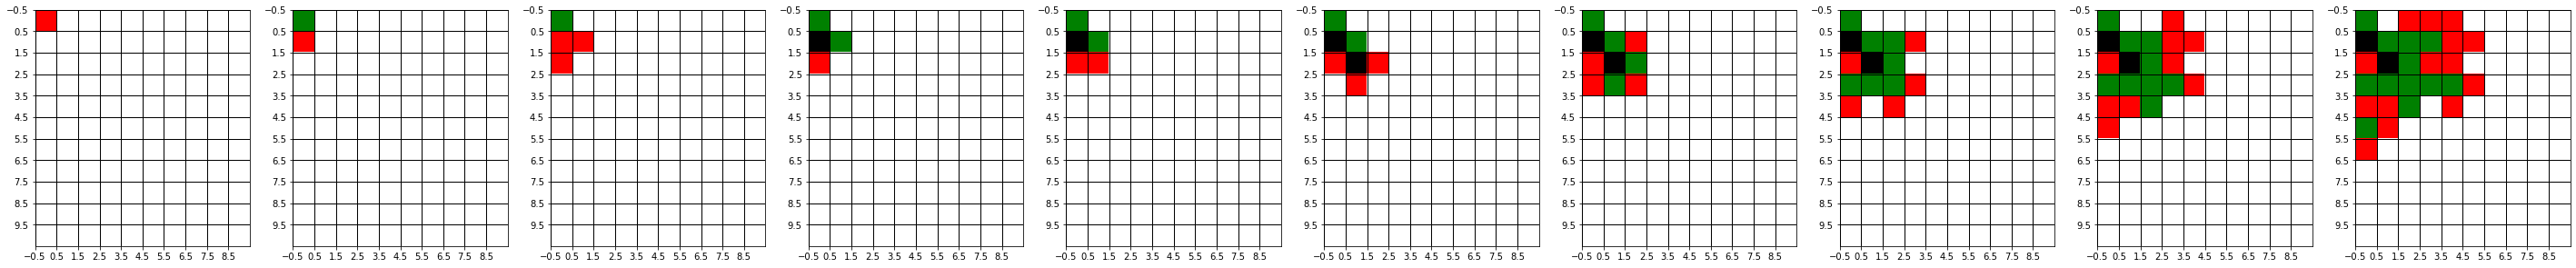

In [9]:
nation.plotAtTimes(times=np.arange(0,10,1))

Visualize snapshots of the epidemic at various stages of the epidemics, e.g. every 10 days

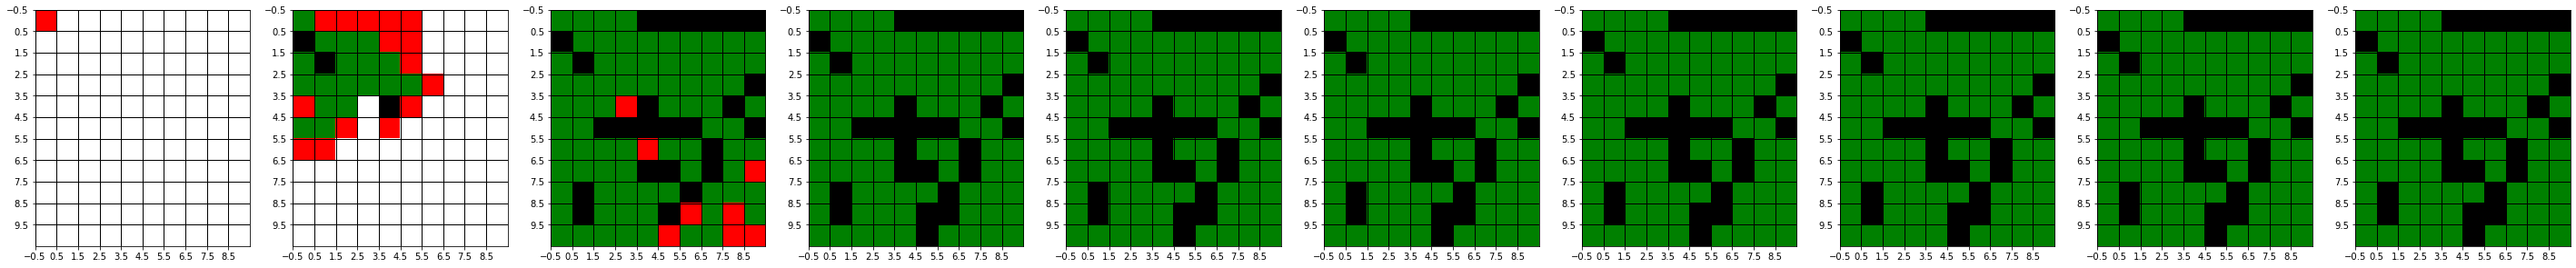

In [10]:
nation.plotAtTimes(times=np.arange(0,nDays,10))

Visualize the evolution of the fraction of infected, recovered, dead and uninfected individuals over time

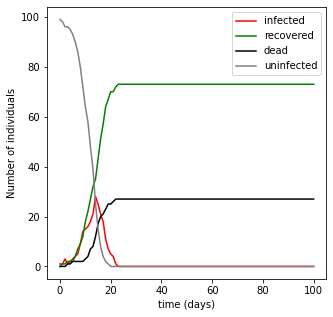

In [11]:
Infected,times = nation.plotInfectedEvolution(doFrac=False,doRet=True,doShow=True)

Print out the returned arrays and their shapes

In [12]:
print(Infected)
print(Infected.shape)
print(times)
print(times.shape)

[ 1  1  3  1  2  3  4  5  9 14 15 16 18 21 28 25 21 18 11  7  5  4  1  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0]
(101,)
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100]
(101,)


Print the number of individuals that were infected at times 0,10,20,..,100:
 - in nation A
 - at the border of nation B

In [13]:
times = np.arange(0,nDays,10)
nInfectedAatTime = np.ones(times.shape)*999
nInfectedBorderBatTime = np.ones(times.shape)*999

for it,time in enumerate(times):
  nInfectedAatTime[it] = nation.getNwithConditionAtTime(time=time,cond='infected')
  nInfectedBorderBatTime[it] = nation.getBorderNwithConditionAtTime(time=time,cond='infected')
  #print(time,nInfectedAatTime[it],nInfectedBorderBatTime[it])

print(nInfectedAatTime)
print(nInfectedBorderBatTime)

[ 1. 15.  5.  0.  0.  0.  0.  0.  0.  0.]
[0. 0. 3. 0. 0. 0. 0. 0. 0. 0.]


#### Exercise 1: Transmission to country B
Let us do the following assumptions: 10x10 individuals over the span of 100 days, no mobility, only NN infection, one initial infected person on day 0. In addition, fix the values: $p_{reco}=0.3$, $p_{death}=0.01$. 

Find the threshold probability of infection p* such that the virus will be transmitted to the bordering country only ~ 5% of the times.

1) Play around with different values of `pInfection`, to get a feeling of the range of values that could prevent the disease from spreading.

2) Decide on a set of 5 values to scan, then run ~50 simulations for each value and determine the fraction of simulations where there is at least one infection at the border of the neighbouring country. 

3) Redo the scan with more simulations (500), to get a more precise estimate (mind that you're after a 5% effect).

4) Plot this fraction for the different values of `pInfection` and fit it to a polynomial (you can use [scipy.optimize.curve_fit](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html))

5) Estimate p* 

In [14]:
def getFractionForPInfScan(pInfectionScan = np.array([0.05, 0.10, 0.2, 0.3, 0.5]), nExps=10, width=10, height=10):

  I0 = 1
  pRecovery = 0.30
  pDeath = 0.01

  nDays = 100

  timeFirstInfections = np.zeros((pInfectionScan.shape[0], nExps))
  fractions = np.zeros((pInfectionScan.shape[0]))

  for ip,p in enumerate(pInfectionScan):
    print('ip={}, p={}'.format(ip,p))

    for iExp in tqdm.tqdm((np.arange(nExps))):
    
      nation = Nation(width=width, height=height, I0=I0)
      nation.createIndividuals()
      nation.setInitialInfected()
      nation.setDisease(pInfection=p,pRecovery=pRecovery,pDeath=pDeath)
    
      for iDay in np.arange(1,nDays+1):
        nation.evolve(1)
        if nation.getNwithConditionAtTime(time=iDay, cond='infected')==0: # break also if there are no more infected people
          break
        if nation.getBorderNwithConditionAtTime(time=iDay,cond='infected') > 0:
          timeFirstInfections[ip,iExp] = iDay
          #print('  time first infection = {}'.format(timeFirstInfections[ip,iexp]))
          break

    fractions[ip] = (timeFirstInfections[ip,:]>0).mean()
  
  return fractions

In [15]:
pInfectionScan_N10_large = np.array([0., 0.05, 0.10, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
fractions_N10_large = getFractionForPInfScan(pInfectionScan_N10_large, nExps=100, width=10, height=10)
fractions_N10_large

ip=0, p=0.0


100%|██████████| 100/100 [00:00<00:00, 338.01it/s]


ip=1, p=0.05


100%|██████████| 100/100 [00:00<00:00, 243.07it/s]


ip=2, p=0.1


100%|██████████| 100/100 [00:00<00:00, 162.55it/s]


ip=3, p=0.15


100%|██████████| 100/100 [00:01<00:00, 86.37it/s]


ip=4, p=0.2


100%|██████████| 100/100 [00:01<00:00, 59.94it/s]


ip=5, p=0.25


100%|██████████| 100/100 [00:02<00:00, 36.92it/s]


ip=6, p=0.3


100%|██████████| 100/100 [00:02<00:00, 33.91it/s]


ip=7, p=0.4


100%|██████████| 100/100 [00:02<00:00, 41.88it/s]


ip=8, p=0.5


100%|██████████| 100/100 [00:02<00:00, 48.59it/s]


ip=9, p=0.6


100%|██████████| 100/100 [00:01<00:00, 56.60it/s]


ip=10, p=0.7


100%|██████████| 100/100 [00:01<00:00, 61.76it/s]


ip=11, p=0.8


100%|██████████| 100/100 [00:01<00:00, 66.16it/s]


ip=12, p=0.9


100%|██████████| 100/100 [00:01<00:00, 74.70it/s]


ip=13, p=1.0


100%|██████████| 100/100 [00:01<00:00, 81.51it/s]


array([0.  , 0.  , 0.  , 0.01, 0.04, 0.27, 0.43, 0.74, 0.92, 0.96, 0.98,
       1.  , 1.  , 1.  ])

In [16]:
pInfectionScan_N10_small = np.array([0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.25])
fractions_N10_small = getFractionForPInfScan(pInfectionScan_N10_small, nExps=100, width=10, height=10)
fractions_N10_small

ip=0, p=0.15


100%|██████████| 100/100 [00:01<00:00, 92.38it/s]


ip=1, p=0.16


100%|██████████| 100/100 [00:01<00:00, 83.26it/s]


ip=2, p=0.17


100%|██████████| 100/100 [00:01<00:00, 77.21it/s]


ip=3, p=0.18


100%|██████████| 100/100 [00:01<00:00, 77.40it/s]


ip=4, p=0.19


100%|██████████| 100/100 [00:01<00:00, 71.35it/s]


ip=5, p=0.2


100%|██████████| 100/100 [00:01<00:00, 52.81it/s]


ip=6, p=0.21


100%|██████████| 100/100 [00:02<00:00, 47.38it/s]


ip=7, p=0.22


100%|██████████| 100/100 [00:02<00:00, 42.41it/s]


ip=8, p=0.23


100%|██████████| 100/100 [00:02<00:00, 48.50it/s]


ip=9, p=0.25


100%|██████████| 100/100 [00:02<00:00, 38.40it/s]


array([0.  , 0.02, 0.01, 0.04, 0.08, 0.06, 0.07, 0.11, 0.09, 0.26])

In [17]:
fractions_N10_1 = getFractionForPInfScan(pInfectionScan_N10_small, nExps=500, width=10, height=10)
fractions_N10_1

ip=0, p=0.15


100%|██████████| 500/500 [00:05<00:00, 86.65it/s] 


ip=1, p=0.16


100%|██████████| 500/500 [00:05<00:00, 92.26it/s] 


ip=2, p=0.17


100%|██████████| 500/500 [00:07<00:00, 66.96it/s]


ip=3, p=0.18


100%|██████████| 500/500 [00:07<00:00, 66.71it/s]


ip=4, p=0.19


100%|██████████| 500/500 [00:09<00:00, 54.36it/s]


ip=5, p=0.2


100%|██████████| 500/500 [00:08<00:00, 56.16it/s] 


ip=6, p=0.21


100%|██████████| 500/500 [00:10<00:00, 45.86it/s]


ip=7, p=0.22


100%|██████████| 500/500 [00:10<00:00, 45.99it/s]


ip=8, p=0.23


100%|██████████| 500/500 [00:10<00:00, 48.32it/s]


ip=9, p=0.25


100%|██████████| 500/500 [00:13<00:00, 38.20it/s]


array([0.01 , 0.004, 0.014, 0.032, 0.052, 0.054, 0.098, 0.114, 0.114,
       0.236])

In [18]:
fractions_N10_2 = getFractionForPInfScan(pInfectionScan_N10_small, nExps=500, width=10, height=10)
fractions_N10_2

ip=0, p=0.15


100%|██████████| 500/500 [00:05<00:00, 91.56it/s] 


ip=1, p=0.16


100%|██████████| 500/500 [00:06<00:00, 71.76it/s] 


ip=2, p=0.17


100%|██████████| 500/500 [00:06<00:00, 71.51it/s] 


ip=3, p=0.18


100%|██████████| 500/500 [00:07<00:00, 69.42it/s] 


ip=4, p=0.19


100%|██████████| 500/500 [00:08<00:00, 59.77it/s]


ip=5, p=0.2


100%|██████████| 500/500 [00:09<00:00, 55.18it/s]


ip=6, p=0.21


100%|██████████| 500/500 [00:09<00:00, 50.25it/s]


ip=7, p=0.22


100%|██████████| 500/500 [00:11<00:00, 43.02it/s]


ip=8, p=0.23


100%|██████████| 500/500 [00:11<00:00, 41.79it/s]


ip=9, p=0.25


100%|██████████| 500/500 [00:11<00:00, 41.68it/s]


array([0.004, 0.014, 0.012, 0.03 , 0.05 , 0.082, 0.068, 0.112, 0.136,
       0.206])

In [19]:
fractions_N10_3 = getFractionForPInfScan(pInfectionScan_N10_small, nExps=500, width=10, height=10)
fractions_N10_3

ip=0, p=0.15


100%|██████████| 500/500 [00:05<00:00, 94.68it/s] 


ip=1, p=0.16


100%|██████████| 500/500 [00:06<00:00, 83.30it/s] 


ip=2, p=0.17


100%|██████████| 500/500 [00:06<00:00, 81.71it/s] 


ip=3, p=0.18


100%|██████████| 500/500 [00:06<00:00, 72.24it/s] 


ip=4, p=0.19


100%|██████████| 500/500 [00:08<00:00, 57.19it/s]


ip=5, p=0.2


100%|██████████| 500/500 [00:08<00:00, 55.91it/s]


ip=6, p=0.21


100%|██████████| 500/500 [00:09<00:00, 52.91it/s]


ip=7, p=0.22


100%|██████████| 500/500 [00:11<00:00, 42.64it/s]


ip=8, p=0.23


100%|██████████| 500/500 [00:11<00:00, 43.26it/s]


ip=9, p=0.25


100%|██████████| 500/500 [00:11<00:00, 42.23it/s]


array([0.008, 0.006, 0.02 , 0.022, 0.054, 0.054, 0.08 , 0.096, 0.142,
       0.214])

In [20]:
fractions_N10_4 = getFractionForPInfScan(pInfectionScan_N10_small, nExps=500, width=10, height=10)
fractions_N10_4

ip=0, p=0.15


100%|██████████| 500/500 [00:05<00:00, 91.11it/s] 


ip=1, p=0.16


100%|██████████| 500/500 [00:06<00:00, 82.40it/s] 


ip=2, p=0.17


100%|██████████| 500/500 [00:06<00:00, 74.65it/s] 


ip=3, p=0.18


100%|██████████| 500/500 [00:07<00:00, 64.70it/s]


ip=4, p=0.19


100%|██████████| 500/500 [00:09<00:00, 54.40it/s]


ip=5, p=0.2


100%|██████████| 500/500 [00:09<00:00, 51.72it/s]


ip=6, p=0.21


100%|██████████| 500/500 [00:10<00:00, 46.60it/s]


ip=7, p=0.22


100%|██████████| 500/500 [00:10<00:00, 45.54it/s]


ip=8, p=0.23


100%|██████████| 500/500 [00:11<00:00, 45.00it/s]


ip=9, p=0.25


100%|██████████| 500/500 [00:11<00:00, 41.95it/s]


array([0.002, 0.008, 0.02 , 0.036, 0.034, 0.056, 0.104, 0.124, 0.132,
       0.226])

In [21]:
fractions_N10_5 = getFractionForPInfScan(pInfectionScan_N10_small, nExps=500, width=10, height=10)
fractions_N10_5

ip=0, p=0.15


100%|██████████| 500/500 [00:05<00:00, 91.43it/s] 


ip=1, p=0.16


100%|██████████| 500/500 [00:05<00:00, 89.22it/s] 


ip=2, p=0.17


100%|██████████| 500/500 [00:06<00:00, 74.61it/s] 


ip=3, p=0.18


100%|██████████| 500/500 [00:06<00:00, 72.65it/s] 


ip=4, p=0.19


100%|██████████| 500/500 [00:06<00:00, 72.02it/s]


ip=5, p=0.2


100%|██████████| 500/500 [00:07<00:00, 63.94it/s]


ip=6, p=0.21


100%|██████████| 500/500 [00:09<00:00, 53.50it/s]


ip=7, p=0.22


100%|██████████| 500/500 [00:09<00:00, 52.94it/s]


ip=8, p=0.23


100%|██████████| 500/500 [00:10<00:00, 46.18it/s]


ip=9, p=0.25


100%|██████████| 500/500 [00:12<00:00, 40.43it/s]


array([0.01 , 0.008, 0.014, 0.02 , 0.022, 0.048, 0.052, 0.096, 0.108,
       0.206])

In [22]:
fractions_N10_6 = getFractionForPInfScan(pInfectionScan_N10_small, nExps=500, width=10, height=10)
fractions_N10_6

ip=0, p=0.15


100%|██████████| 500/500 [00:05<00:00, 83.64it/s] 


ip=1, p=0.16


100%|██████████| 500/500 [00:05<00:00, 89.76it/s] 


ip=2, p=0.17


100%|██████████| 500/500 [00:06<00:00, 74.30it/s] 


ip=3, p=0.18


100%|██████████| 500/500 [00:06<00:00, 71.58it/s]


ip=4, p=0.19


100%|██████████| 500/500 [00:08<00:00, 58.78it/s]


ip=5, p=0.2


100%|██████████| 500/500 [00:08<00:00, 58.74it/s]


ip=6, p=0.21


100%|██████████| 500/500 [00:10<00:00, 48.35it/s]


ip=7, p=0.22


100%|██████████| 500/500 [00:10<00:00, 49.09it/s]


ip=8, p=0.23


100%|██████████| 500/500 [00:11<00:00, 44.26it/s]


ip=9, p=0.25


100%|██████████| 500/500 [00:11<00:00, 45.31it/s]


array([0.01 , 0.008, 0.01 , 0.024, 0.034, 0.06 , 0.078, 0.1  , 0.152,
       0.198])

In [23]:
def poly3(x,a,b,c,d):
  return a + b*x + c*x**2 + d*x**3

def poly2(x,a,b,c):
  return a + b*x + c*x**2

def poly2Fit(x,a=0.75141293, b=-9.18992206, c=28.54122515):
  return a + b*x + c*x**2

def expon(x,a,b):
  return a * np.exp(b*x)

def Logistic(x,x0,L,k):
  return L/(1+np.exp(k*(x-x0)))

In [24]:
yall = np.vstack((fractions_N10_1, fractions_N10_2, fractions_N10_3,fractions_N10_4,fractions_N10_5,fractions_N10_6))
x = pInfectionScan_N10_small
y = yall.mean(axis=0)
yerr = np.sqrt(yall.var(axis=0))
y,yerr

(array([0.00733333, 0.008     , 0.015     , 0.02733333, 0.041     ,
        0.059     , 0.08      , 0.107     , 0.13066667, 0.21433333]),
 array([0.00319722, 0.00305505, 0.00378594, 0.00573488, 0.01176152,
        0.01087811, 0.01747379, 0.01044031, 0.01530432, 0.01298289]))

In [25]:
from scipy.stats import chi2

def fitRoutine(f,x,y,yerr=None):
  
  if yerr is not None:
    popt,pcov = curve_fit(f, x, y, sigma=yerr, absolute_sigma=True) # important to have absolute_sigma=True
  
  else:
    popt,pcov = curve_fit(f, x, y) 

  print('\nFitted parameters')
  for i,ip in enumerate(popt):
    print('i={} fitted param:\t{:.2f}\t+/-\t{:.2f}'.format(i,popt[i], pcov[i,i]**0.5))

  if yerr is not None: 
    chisq = (((y - f(x, *popt) ) / yerr)**2).sum()
    red_chisq = chisq / (len(x)-len(popt)) # ndof = number of meas - n of fitted params
    prob = 1-chi2.cdf(chisq, (len(x)-len(popt)))
    print('\nvalue of Chisquare            {:.3f}'.format(chisq))
    print('value of reduced Chisquare    {:.3f}'.format(red_chisq))
    print('P-value                       {:.3f}'.format(prob))
  
  return popt,pcov

In [26]:
popt_2,pcov_2 = fitRoutine(poly2,x,y,yerr)
popt_3,pcov_3 = fitRoutine(poly3,x,y,yerr)
popt_exp,pcov_exp = fitRoutine(expon,x,y,yerr)
popt_log,pcov_log = fitRoutine(Logistic,x,y,yerr)


Fitted parameters
i=0 fitted param:	0.47	+/-	0.09
i=1 fitted param:	-6.12	+/-	1.01
i=2 fitted param:	20.43	+/-	2.67

value of Chisquare            0.526
value of reduced Chisquare    0.075
P-value                       0.999

Fitted parameters
i=0 fitted param:	0.43	+/-	0.65
i=1 fitted param:	-5.59	+/-	10.43
i=2 fitted param:	17.59	+/-	55.09
i=3 fitted param:	4.93	+/-	95.57

value of Chisquare            0.523
value of reduced Chisquare    0.087
P-value                       0.998

Fitted parameters
i=0 fitted param:	0.00	+/-	0.00
i=1 fitted param:	31.72	+/-	1.50

value of Chisquare            11.418
value of reduced Chisquare    1.427
P-value                       0.179

Fitted parameters
i=0 fitted param:	0.24	+/-	0.01
i=1 fitted param:	0.32	+/-	0.07
i=2 fitted param:	-45.34	+/-	4.95

value of Chisquare            1.834
value of reduced Chisquare    0.262
P-value                       0.968


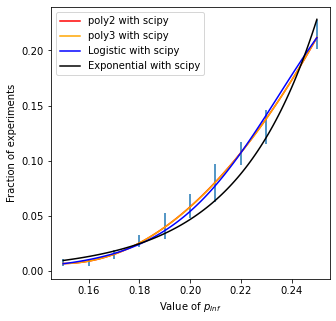

In [27]:
bigx = np.linspace(0.15, 0.25, 100)

fig,ax = plt.subplots(1,1,figsize=(5, 5))

ax.errorbar(x, y, yerr, fmt="none")

ax.plot(bigx,poly2(bigx,*popt_2),label='poly2 with scipy', color='red')

ax.plot(bigx,poly3(bigx,*popt_3), label='poly3 with scipy', color='orange')

ax.plot(bigx,Logistic(bigx,*popt_log), label='Logistic with scipy', color='blue')

ax.plot(bigx,expon(bigx,*popt_exp), label='Exponential with scipy', color='black')

ax.legend(loc='upper left', frameon=True)

ax.set_xlabel('Value of $p_{Inf}$')
ax.set_ylabel('Fraction of experiments')
ax.set_title('')
plt.show()

In [28]:
def poly2_inv(y,a,b,c):
  return (-b + np.sqrt(b**2 - 4*c*(a-y)) ) / (2. * c)

In [29]:
pstar=poly2_inv(0.05,*popt_2)
print('Extracted value of p*={:.3f}'.format(pstar)) 

Extracted value of p*=0.196


#### Exercise 2 Transmission to Country B, as a function of N
Repeat exercise 1 for different values of NxN. 

Scan e.g. N=5, N=10, N=20 (do not take N too high, otherwise simulation will take forever)

How does p* depend on N ?

Suggestion: use a similar range as in the previous exercise. 
Start with fewer experiments, to get an idea of the trend. Then run more simulations.

In [30]:
fractions_N10 = getFractionForPInfScan(pInfectionScan_N10_small, nExps=500, width=10, height=10)
fractions_N10

ip=0, p=0.15


100%|██████████| 500/500 [00:05<00:00, 86.44it/s] 


ip=1, p=0.16


100%|██████████| 500/500 [00:05<00:00, 90.07it/s] 


ip=2, p=0.17


100%|██████████| 500/500 [00:07<00:00, 65.57it/s]


ip=3, p=0.18


100%|██████████| 500/500 [00:07<00:00, 66.87it/s]


ip=4, p=0.19


100%|██████████| 500/500 [00:08<00:00, 58.61it/s] 


ip=5, p=0.2


100%|██████████| 500/500 [00:10<00:00, 47.03it/s]


ip=6, p=0.21


100%|██████████| 500/500 [00:09<00:00, 50.48it/s]


ip=7, p=0.22


100%|██████████| 500/500 [00:09<00:00, 51.91it/s]


ip=8, p=0.23


100%|██████████| 500/500 [00:10<00:00, 45.85it/s]


ip=9, p=0.25


100%|██████████| 500/500 [00:12<00:00, 41.63it/s]


array([0.004, 0.012, 0.014, 0.02 , 0.036, 0.062, 0.08 , 0.084, 0.13 ,
       0.212])

In [31]:
fractions_N20 = getFractionForPInfScan(pInfectionScan_N10_small, nExps=500, width=15, height=15)
fractions_N20

ip=0, p=0.15


100%|██████████| 500/500 [00:12<00:00, 41.15it/s]


ip=1, p=0.16


100%|██████████| 500/500 [00:14<00:00, 34.19it/s]


ip=2, p=0.17


100%|██████████| 500/500 [00:16<00:00, 29.61it/s]


ip=3, p=0.18


100%|██████████| 500/500 [00:22<00:00, 22.08it/s]


ip=4, p=0.19


100%|██████████| 500/500 [00:19<00:00, 25.20it/s]


ip=5, p=0.2


100%|██████████| 500/500 [00:29<00:00, 16.79it/s]


ip=6, p=0.21


100%|██████████| 500/500 [00:31<00:00, 15.72it/s]


ip=7, p=0.22


100%|██████████| 500/500 [00:32<00:00, 15.31it/s]


ip=8, p=0.23


100%|██████████| 500/500 [00:36<00:00, 13.54it/s]


ip=9, p=0.25


100%|██████████| 500/500 [00:48<00:00, 10.32it/s]


array([0.   , 0.   , 0.006, 0.018, 0.008, 0.018, 0.062, 0.048, 0.086,
       0.184])

In [32]:
fractions_N5 = getFractionForPInfScan(pInfectionScan_N10_small, nExps=500, width=5, height=5)
fractions_N5

ip=0, p=0.15


100%|██████████| 500/500 [00:01<00:00, 371.07it/s]


ip=1, p=0.16


100%|██████████| 500/500 [00:01<00:00, 381.92it/s]


ip=2, p=0.17


100%|██████████| 500/500 [00:01<00:00, 379.30it/s]


ip=3, p=0.18


100%|██████████| 500/500 [00:01<00:00, 354.87it/s]


ip=4, p=0.19


100%|██████████| 500/500 [00:01<00:00, 331.85it/s]


ip=5, p=0.2


100%|██████████| 500/500 [00:01<00:00, 354.43it/s]


ip=6, p=0.21


100%|██████████| 500/500 [00:01<00:00, 322.55it/s]


ip=7, p=0.22


100%|██████████| 500/500 [00:01<00:00, 330.58it/s]


ip=8, p=0.23


100%|██████████| 500/500 [00:01<00:00, 314.67it/s]


ip=9, p=0.25


100%|██████████| 500/500 [00:01<00:00, 299.94it/s]


array([0.042, 0.058, 0.068, 0.098, 0.116, 0.144, 0.17 , 0.224, 0.212,
       0.312])

In [33]:
x=pInfectionScan_N10_small

popt_N10,pcov_N10 = fitRoutine(poly2,x,fractions_N10)
popt_N20,pcov_N20 = fitRoutine(poly2,x,fractions_N20)
popt_N5,pcov_N5   = fitRoutine(poly2,x,fractions_N5)

pstar_N10=poly2_inv(0.05,*popt_N10)
pstar_N20=poly2_inv(0.05,*popt_N20)
pstar_N5=poly2_inv(0.05,*popt_N5)

print('For N=5,  Extracted value of p*={:.3f}'.format(pstar_N5)) 
print('For N=10, Extracted value of p*={:.3f}'.format(pstar_N10)) 
print('For N=20, Extracted value of p*={:.3f}'.format(pstar_N20)) 



Fitted parameters
i=0 fitted param:	0.53	+/-	0.11
i=1 fitted param:	-6.79	+/-	1.15
i=2 fitted param:	21.94	+/-	2.90

Fitted parameters
i=0 fitted param:	0.75	+/-	0.19
i=1 fitted param:	-8.88	+/-	1.99
i=2 fitted param:	26.31	+/-	5.00

Fitted parameters
i=0 fitted param:	0.10	+/-	0.17
i=1 fitted param:	-2.23	+/-	1.74
i=2 fitted param:	12.26	+/-	4.37
For N=5,  Extracted value of p*=0.156
For N=10, Extracted value of p*=0.199
For N=20, Extracted value of p*=0.213


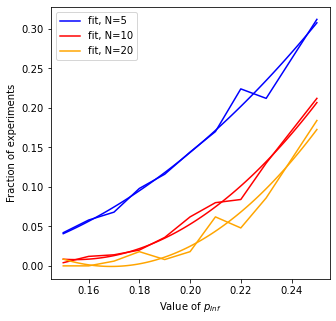

In [34]:
bigx = np.linspace(0.15, 0.25, 100)

fig,ax = plt.subplots(1,1,figsize=(5, 5))

ax.plot(x, fractions_N5, color='blue')
ax.plot(x, fractions_N10, color='red')
ax.plot(x, fractions_N20, color='orange')

ax.plot(bigx,poly2(bigx,*popt_N5),label='fit, N=5', color='blue')
ax.plot(bigx,poly2(bigx,*popt_N10),label='fit, N=10', color='red')
ax.plot(bigx,poly2(bigx,*popt_N20),label='fit, N=20', color='orange')

ax.legend(loc='upper left', frameon=True)

ax.set_xlabel('Value of $p_{Inf}$')
ax.set_ylabel('Fraction of experiments')
ax.set_title('')
plt.show()

Result: In order to contain the pandemic in a smaller country, one needs a less infective disease

#### Exercise 3 Quarantine versus free travel
So far we have considered cases where the individuals cannot move from their fixed position. What happens when the people are allowed to move?

Let us concentrate on country A; fix the various parameters of the simulation to some choice and compare the cases when
`_maxTravelDistance=0` = 0 and `_maxTravelDistance=M`, with M some value of your choice.

In particular:

1. How does the number of total infections varies with time in the two cases? Plot the curve.  
2. For the two cases separately, repeat the simulation a few times, determine an average curve and its variance 
2. Comment on the shapes of the average curves in the two cases. 

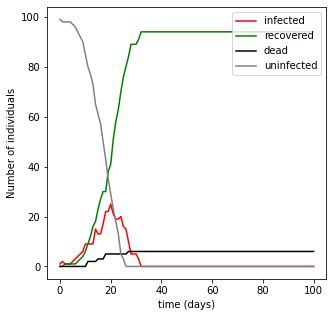

In [35]:
nDays = 100

nation = Nation(width=10, height=10, I0=1, maxTravelDistance=0)
nation.createIndividuals()
nation.setInitialInfected()
nation.setDisease(pInfection=0.50,pRecovery=0.25,pDeath=0.02)
nation.evolve(nDays)

Infected_mtd0,times = nation.plotInfectedEvolution(doFrac=False,doRet=True)

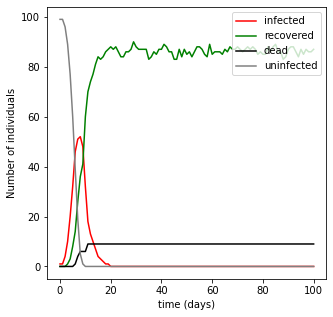

In [36]:
nDays = 100

nation = Nation(width=10, height=10, I0=1, maxTravelDistance=5)
nation.createIndividuals()
nation.setInitialInfected()
nation.setDisease(pInfection=0.50,pRecovery=0.25,pDeath=0.02)
nation.evolve(nDays)

Infected_mtd5,times = nation.plotInfectedEvolution(doFrac=False,doRet=True)

In [37]:
def getAvgCurves(maxTravelDistance=0):
  nExp = 50
  nDays = 100
  listInfected = []

  for iExp in tqdm.tqdm((np.arange(nExp))):

    nation = Nation(width=10, height=10, I0=1, maxTravelDistance=maxTravelDistance)
    nation.createIndividuals()
    nation.setInitialInfected()
    nation.setDisease(pInfection=0.50,pRecovery=0.25,pDeath=0.02)
    nation.evolve(nDays-1)

    Infected,times = nation.plotInfectedEvolution(doFrac=False,doRet=True,doShow=False)
    listInfected.append(Infected)

  arInfecteds = np.vstack((listInfected[:]))
  AvgInfecteds = arInfecteds.mean(axis=0)
  StdDevInfecteds = np.sqrt(arInfecteds.var(axis=0))

  #fit = np.polyfit(times,AvgInfecteds,9)
  #fit_fn = np.poly1d(fit)

  fix,ax = plt.subplots(1,1,figsize=(5,5))
  for iInfected in listInfected:
    ax.plot(times,iInfected, '-', linewidth='0.2')
  ax.plot(times,AvgInfecteds,                       color='magenta',label='$\mu$')
  ax.plot(times,AvgInfecteds+StdDevInfecteds, color='r', label='$\mu+\sigma$')
  ax.plot(times,AvgInfecteds-StdDevInfecteds, color='r', label='$\mu-\sigma$')
  #ax.plot(times,fit_fn(times),                 color='b',label='fit')

  return times,AvgInfecteds,StdDevInfecteds

100%|██████████| 50/50 [01:03<00:00,  1.27s/it]


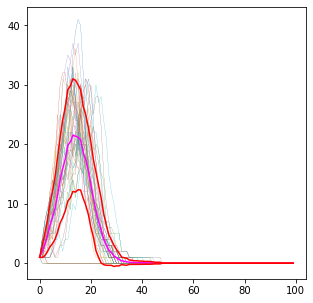

In [38]:
times,AvgInfecteds_0,StdDevInfecteds_0=getAvgCurves(maxTravelDistance=0)

100%|██████████| 50/50 [01:35<00:00,  1.92s/it]


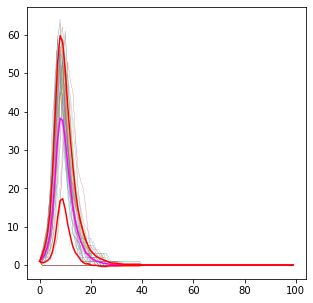

In [39]:
times,AvgInfecteds_5,StdDevInfecteds_5=getAvgCurves(maxTravelDistance=5)

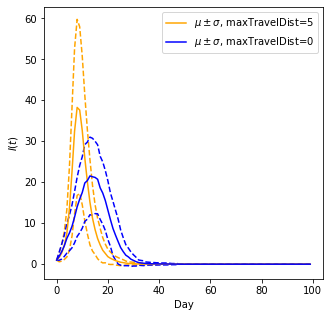

In [40]:
fix,ax = plt.subplots(1,1,figsize=(5,5))
ax.plot(times,AvgInfecteds_5+StdDevInfecteds_5, '--',color='orange',   )
ax.plot(times,AvgInfecteds_5-StdDevInfecteds_5, '--',color='orange', )

ax.plot(times,AvgInfecteds_0+StdDevInfecteds_0, '--', color='blue')
ax.plot(times,AvgInfecteds_0-StdDevInfecteds_0, '--', color='blue')

ax.plot(times,AvgInfecteds_5, color='orange',label='$\mu\pm\sigma$, maxTravelDist=5')
ax.plot(times,AvgInfecteds_0, color='blue',label='$\mu\pm\sigma$, maxTravelDist=0')


ax.set_xlabel('Day')
ax.set_ylabel('$I(t)$')


ax.legend(loc='upper right')

Answer: when the position of the individuals in the grid is fixed, it very much resembles a country with quarantine, i.e. we observe that the curve is flattened, compared to the case where the individuals can move freely in the country

#### Bonus exercise: analytic versus numerical simulation

For the case of restricted travel (maxTravelDistance=0) and in the simplified situation where where pDeath=0, pRecovery=0,: compare the curves obtained by the simulation and the analytic solution of the differential equation obtained in the beginning: do they match? 

In [41]:
nDays = 100
nExp=100

n1_Inf = []
n2_Inf = []

for iExp in tqdm.tqdm(range(nExp)):
  nation1 = Nation(width=10, height=10, I0=1, maxTravelDistance=0)
  nation1.createIndividuals()
  nation1.setInitialInfected()
  nation1.setDisease(pInfection=0.05,pRecovery=0.,pDeath=0.)
  nation1.evolve(nDays)
  Infected,times = nation1.plotInfectedEvolution(doFrac=False,doRet=True,doShow=False)
  n1_Inf.append(Infected)

  nation2 = Nation(width=10, height=10, I0=1, maxTravelDistance=0)
  nation2.createIndividuals()
  nation2.setInitialInfected()
  nation2.setDisease(pInfection=1.0,pRecovery=0.,pDeath=0.)
  nation2.evolve(nDays)
  Infected,times = nation2.plotInfectedEvolution(doFrac=False,doRet=True,doShow=False)
  n2_Inf.append(Infected)

100%|██████████| 100/100 [04:37<00:00,  2.78s/it]


In [42]:
ar_n1_Inf = np.vstack((n1_Inf[:]))
avg_n1_Inf = ar_n1_Inf.mean(axis=0)
var_n1_Inf = ar_n1_Inf.var(axis=0)

ar_n2_Inf = np.vstack((n2_Inf[:]))
avg_n2_Inf = ar_n2_Inf.mean(axis=0)
var_n2_Inf = ar_n2_Inf.var(axis=0)

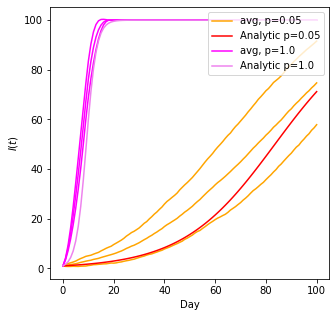

In [43]:
fix,ax = plt.subplots(1,1,figsize=(5,5))
ax.plot(times,avg_n1_Inf,                     color='orange',label='avg, p=0.05')
ax.plot(times,avg_n1_Inf+np.sqrt(var_n1_Inf), color='orange',   )
ax.plot(times,avg_n1_Inf-np.sqrt(var_n1_Inf), color='orange', )

ax.plot(times,np.array([I(t,N2=100,I0=1,k=1.1,p=0.05) for t in times]), label='Analytic p=0.05', color='r')


ax.plot(times,avg_n2_Inf,                     color='magenta',label='avg, p=1.0')
ax.plot(times,avg_n2_Inf+np.sqrt(var_n2_Inf), color='magenta')
ax.plot(times,avg_n2_Inf-np.sqrt(var_n2_Inf), color='magenta')

ax.plot(times,np.array([I(t,N2=100,I0=1,k=0.5,p=1.0) for t in times]), label='Analytic p=1.0', color='violet')

ax.set_xlabel('Day')
ax.set_ylabel('$I(t)$')


ax.legend(loc='upper right')


#ax.legend(loc='lower right', frameon=True) 
plt.show()

### Statistics, some useful examples
Example usage of multinomial distribution:
I do 10000 experiments where I throw the three-faced dice once; each face has a different probability

In [44]:
results = rg.multinomial(1, [0.1,0.5,1-0.1-0.5], size=10000)
print(results[:,0].mean())
print(results[:,1].mean())
print(results[:,2].mean())
a = rg.multinomial(1, [0.1,0.5,1-0.1-0.5], size=1)
print(a)
print(a.reshape(-1))
b,c,d=a.reshape(-1)
print(b,c,d)

0.1012
0.5078
0.391
[[0 1 0]]
[0 1 0]
0 1 0


Average Number of NN?

In [45]:
def avgNumberNNs(width=10.,height=10.):
  '''
  return the average number of Nearest Neighbours in this setting
  '''
  N=width*height
  weights   = np.array([(N-2)**2, (N-2)*4, 4]) / N**2
  assert weights.sum()==1
  number_NNs= np.array([4,3,1])
  return (weights * number_NNs).sum()
print(avgNumberNNs(3,3),avgNumberNNs(10,10),avgNumberNNs(50,50))

3.5061728395061733 3.9596 3.99839936
